# Vibrational structure

NH3 Vibrational Ground State VQE with Qiskit

==================== COBYLA Optimizer ====================
Setting up Qiskit VQE for NH3 vibrational ground state...
Number of qubits: 10
Ansatz repetitions: 10
Hamiltonian terms: 54
Exact ground state energy: 0.014775 Hartree
In cm^-1: 3243.05
Ansatz parameters: 220

Starting VQE optimization with COBYLA...
Iteration 10: Energy = 0.041169 Ha
Iteration 20: Energy = 0.040330 Ha
Iteration 30: Energy = 0.040633 Ha
Iteration 40: Energy = 0.040130 Ha
Iteration 50: Energy = 0.040375 Ha
Iteration 60: Energy = 0.040181 Ha
Iteration 70: Energy = 0.040001 Ha
Iteration 80: Energy = 0.039710 Ha
Iteration 90: Energy = 0.039763 Ha
Iteration 100: Energy = 0.039402 Ha
Iteration 110: Energy = 0.039891 Ha
Iteration 120: Energy = 0.039566 Ha
Iteration 130: Energy = 0.039046 Ha
Iteration 140: Energy = 0.038967 Ha
Iteration 150: Energy = 0.039756 Ha
Iteration 160: Energy = 0.039392 Ha
Iteration 170: Energy = 0.038819 Ha
Iteration 180: Energy = 0.039336 Ha
Itera

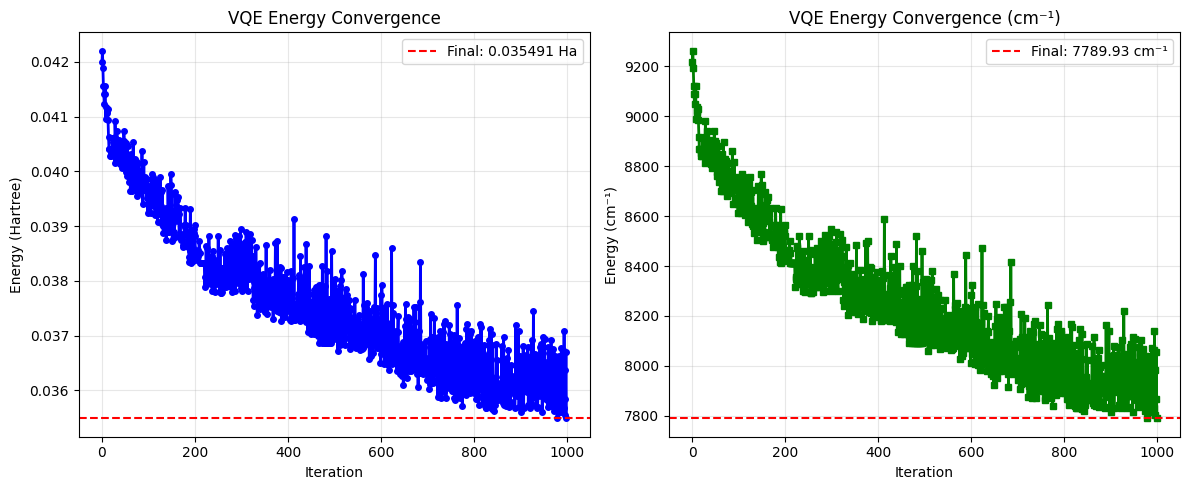


Ground State Analysis:
Significant state amplitudes:
|0000111001⟩: 0.0332-0.0966j (prob: 0.0104)
|0000111101⟩: 0.0784+0.0795j (prob: 0.0125)
|0001111101⟩: 0.1068+0.0041j (prob: 0.0114)
|1000110111⟩: 0.1003+0.0143j (prob: 0.0103)

Expectation value ⟨H⟩: 0.035491+0.000000j Hartree

==================== SPSA Optimizer ====================
Setting up Qiskit VQE for NH3 vibrational ground state...
Number of qubits: 10
Ansatz repetitions: 10
Hamiltonian terms: 54
Exact ground state energy: 0.014775 Hartree
In cm^-1: 3243.05
Ansatz parameters: 220

Starting VQE optimization with SPSA...
Iteration 10: Energy = 0.042006 Ha
Iteration 20: Energy = 0.041489 Ha
Iteration 30: Energy = 0.041318 Ha
Iteration 40: Energy = 0.040732 Ha
Iteration 50: Energy = 0.042488 Ha
Iteration 60: Energy = 0.040436 Ha
Iteration 70: Energy = 0.039942 Ha
Iteration 80: Energy = 0.041310 Ha
Iteration 90: Energy = 0.041264 Ha
Iteration 100: Energy = 0.040954 Ha
Iteration 110: Energy = 0.041586 Ha
Iteration 120: Energy = 0

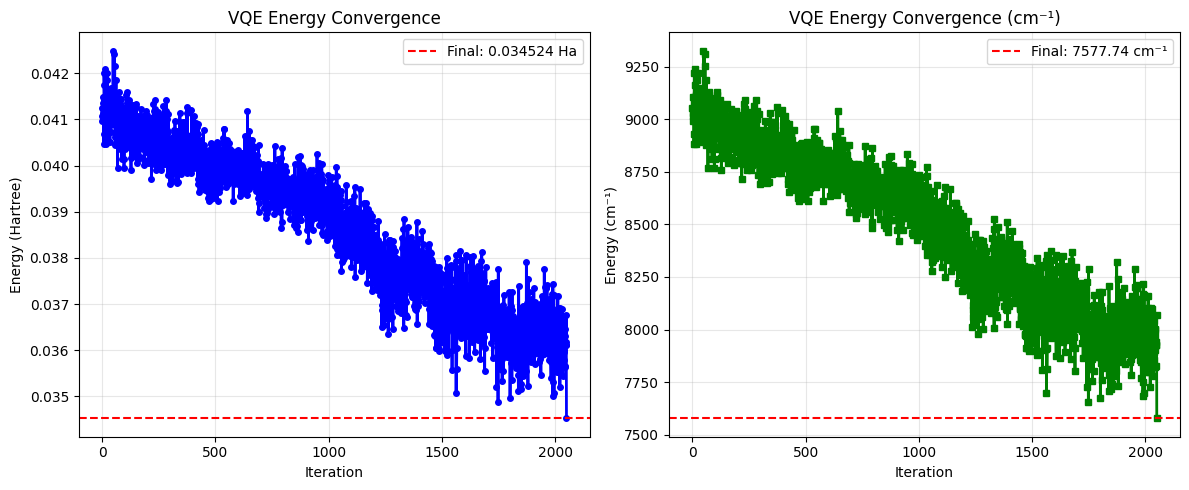


Ground State Analysis:
Significant state amplitudes:
|0001100111⟩: 0.0973+0.0403j (prob: 0.0111)
|0001101111⟩: -0.1143-0.0136j (prob: 0.0133)

Expectation value ⟨H⟩: 0.034524+0.000000j Hartree

==================== Optimizer Comparison ====================


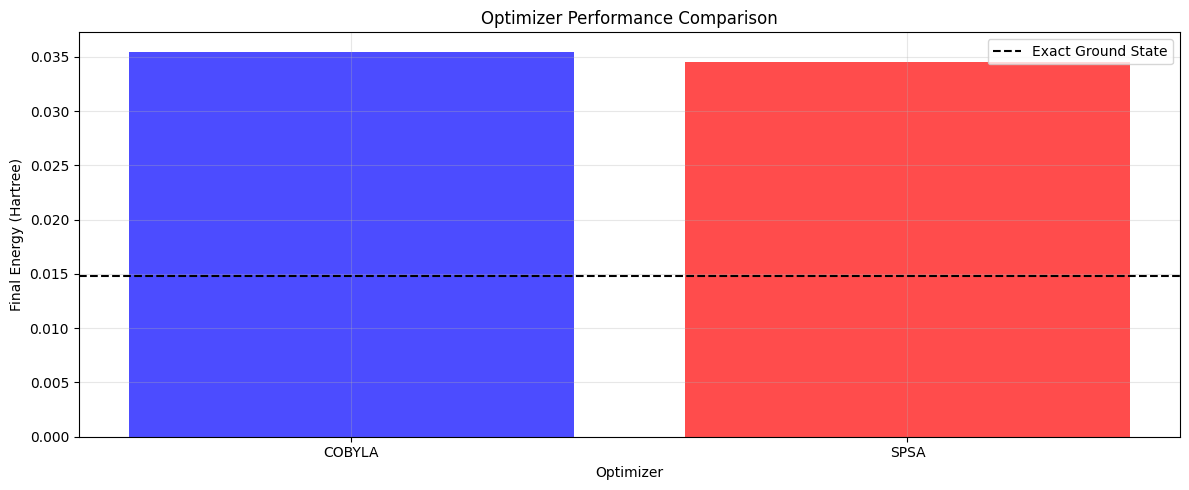


==================== Ansatz Comparison ====================

Comparing different ansatz approaches:

Testing ansatz with 1 repetitions...
Setting up Qiskit VQE for NH3 vibrational ground state...
Number of qubits: 8
Ansatz repetitions: 1
Hamiltonian terms: 37
Exact ground state energy: 0.015775 Hartree
In cm^-1: 3462.54
Ansatz parameters: 32

Starting VQE optimization with COBYLA...
Iteration 10: Energy = 0.031517 Ha
Iteration 20: Energy = 0.025210 Ha
Iteration 30: Energy = 0.022170 Ha
Iteration 40: Energy = 0.026741 Ha
Iteration 50: Energy = 0.024374 Ha
Iteration 60: Energy = 0.022039 Ha
Iteration 70: Energy = 0.021305 Ha
Iteration 80: Energy = 0.021078 Ha
Iteration 90: Energy = 0.020490 Ha
Iteration 100: Energy = 0.019726 Ha
Iteration 110: Energy = 0.019388 Ha
Iteration 120: Energy = 0.018515 Ha
Iteration 130: Energy = 0.018223 Ha
Iteration 140: Energy = 0.017814 Ha
Iteration 150: Energy = 0.017661 Ha

VQE Results:
VQE ground state energy: 0.017661 Hartree
In cm^-1: 3876.42
Error: 0

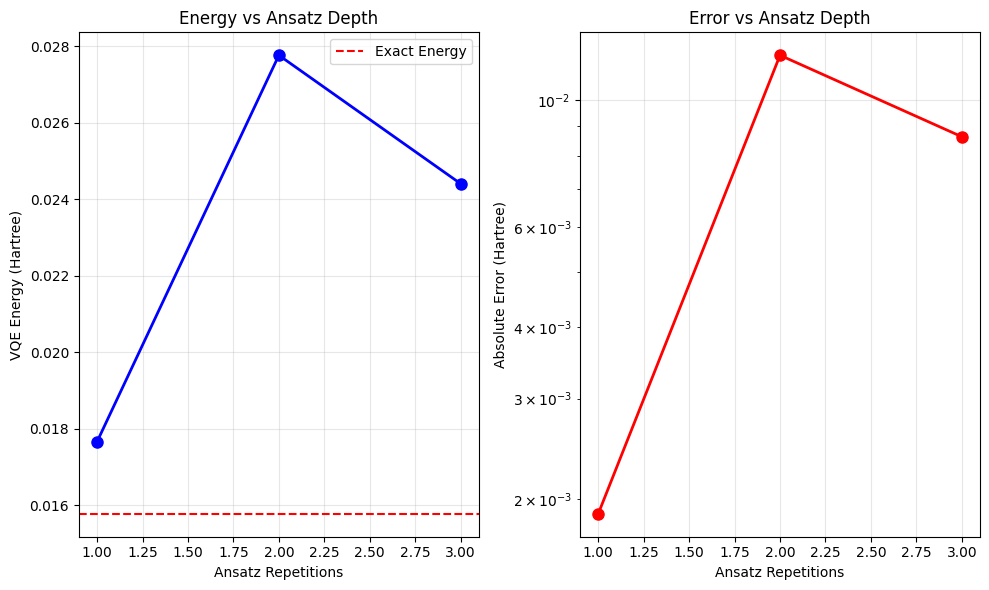


Simulation completed successfully!
Key insights:
- VQE successfully finds ground vibrational state
- Ansatz depth affects accuracy vs. circuit complexity
- Different optimizers show varying convergence behavior


In [18]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Dict, Any

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator
from qiskit_algorithms.optimizers import COBYLA, SPSA, L_BFGS_B
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.circuit.library import EfficientSU2

class NH3_Qiskit_VQE:
    """
    Variational Quantum Eigensolver for NH3 ground state vibrational energy using Qiskit
    """
    
    def __init__(self, n_qubits: int = 4, reps: int = 2):
        """
        Initialize the Qiskit VQE simulator
        
        Args:
            n_qubits: Number of qubits for the quantum circuit
            reps: Number of repetitions for the ansatz circuit
        """
        self.n_qubits = n_qubits
        self.reps = reps
        
        # NH3 vibrational parameters (from experimental data)
        self.omega_s = 3337  # cm^-1, symmetric stretch
        self.omega_as = 3444  # cm^-1, asymmetric stretch  
        self.omega_bend = 950  # cm^-1, bending mode
        self.omega_deform = 1627  # cm^-1, deformation mode
        
        # Convert to atomic units (Hartree)
        self.cm_to_hartree = 4.556e-6
        self.omega_s_au = self.omega_s * self.cm_to_hartree
        self.omega_as_au = self.omega_as * self.cm_to_hartree
        self.omega_bend_au = self.omega_bend * self.cm_to_hartree
        self.omega_deform_au = self.omega_deform * self.cm_to_hartree
        
        # Coupling constants
        self.coupling = 0.001  # Inter-mode coupling strength
        
        # VQE tracking
        self.energy_history = []
        self.iteration_count = 0
        
    def create_hamiltonian_pauli(self) -> SparsePauliOp:
        """
        Create the vibrational Hamiltonian as a Pauli operator sum
        
        Returns:
            SparsePauliOp: Hamiltonian in Pauli string representation
        """
        pauli_list = []
        coeffs = []
        
        # Zero-point energy (constant term)
        zpe = 0.5 * (self.omega_s_au + self.omega_as_au + 2*self.omega_bend_au)
        pauli_list.append('I' * self.n_qubits)
        coeffs.append(zpe)
        
        # Single-mode energies: ω_i * (I - Z_i)/2
        # This maps |0⟩ → 0, |1⟩ → ω_i for each qubit
        frequencies = [self.omega_s_au, self.omega_as_au, 
                      self.omega_bend_au, self.omega_deform_au]
        
        for i in range(self.n_qubits):
            if i < len(frequencies):
                omega_i = frequencies[i]
                
                # Identity term: ω_i/2
                pauli_str = 'I' * self.n_qubits
                pauli_list.append(pauli_str)
                coeffs.append(omega_i / 2)
                
                # Z term: -ω_i/2 * Z_i
                pauli_str = 'I' * i + 'Z' + 'I' * (self.n_qubits - i - 1)
                pauli_list.append(pauli_str)
                coeffs.append(-omega_i / 2)
        
        # Coupling terms: coupling * Z_i * Z_j
        for i in range(self.n_qubits):
            for j in range(i + 1, self.n_qubits):
                pauli_str = ['I'] * self.n_qubits
                pauli_str[i] = 'Z'
                pauli_str[j] = 'Z'
                pauli_list.append(''.join(pauli_str))
                coeffs.append(self.coupling)
        
        return SparsePauliOp.from_list(list(zip(pauli_list, coeffs)))
    
    def create_ansatz_circuit(self) -> QuantumCircuit:
        """
        Create parameterized ansatz circuit using EfficientSU2
        
        Returns:
            QuantumCircuit: Parameterized quantum circuit
        """
        ansatz = EfficientSU2(
            num_qubits=self.n_qubits,
            reps=self.reps,
            entanglement='linear',
            insert_barriers=True
        )
        return ansatz
    
    def create_custom_ansatz(self) -> QuantumCircuit:
        """
        Create custom ansatz circuit with hardware-efficient structure
        
        Returns:
            QuantumCircuit: Custom parameterized circuit
        """
        # Create parameter vector
        num_params = 2 * self.n_qubits * (self.reps + 1)
        params = ParameterVector('θ', num_params)
        
        qc = QuantumCircuit(self.n_qubits)
        param_idx = 0
        
        # Initial layer of RY rotations
        for qubit in range(self.n_qubits):
            qc.ry(params[param_idx], qubit)
            param_idx += 1
        
        # Alternating layers of entanglement and rotations
        for rep in range(self.reps):
            # Entangling layer (linear connectivity)
            for qubit in range(self.n_qubits - 1):
                qc.cx(qubit, qubit + 1)
            
            # Rotation layer
            for qubit in range(self.n_qubits):
                qc.ry(params[param_idx], qubit)
                param_idx += 1
                qc.rz(params[param_idx], qubit)
                param_idx += 1
        
        return qc
    
    def callback_function(self, eval_count, params, mean, std):
        """Callback function to track VQE progress"""
        self.iteration_count += 1
        self.energy_history.append(mean)
        
        if self.iteration_count % 10 == 0:
            print(f"Iteration {self.iteration_count}: Energy = {mean:.6f} Ha")
    
    def run_classical_reference(self, hamiltonian: SparsePauliOp) -> Tuple[float, np.ndarray]:
        """
        Compute exact ground state for comparison
        
        Args:
            hamiltonian: Hamiltonian operator
            
        Returns:
            Ground state energy and eigenvector
        """
        # Convert to dense matrix for small systems
        H_matrix = hamiltonian.to_matrix()
        eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)
        
        ground_energy = eigenvalues[0]
        ground_state = eigenvectors[:, 0]
        
        return ground_energy, ground_state
    
    def run_vqe_qiskit(self, optimizer_name: str = 'COBYLA', 
                      max_iterations: int = 200, 
                      use_custom_ansatz: bool = False) -> Dict[str, Any]:
        """
        Run VQE using Qiskit's built-in VQE algorithm
        
        Args:
            optimizer_name: Name of the optimizer ('COBYLA', 'SPSA', 'L_BFGS_B')
            max_iterations: Maximum number of iterations
            use_custom_ansatz: Whether to use custom ansatz instead of EfficientSU2
            
        Returns:
            Dictionary with VQE results
        """
        print("Setting up Qiskit VQE for NH3 vibrational ground state...")
        print(f"Number of qubits: {self.n_qubits}")
        print(f"Ansatz repetitions: {self.reps}")
        
        # Create Hamiltonian
        hamiltonian = self.create_hamiltonian_pauli()
        print(f"Hamiltonian terms: {len(hamiltonian.paulis)}")
        
        # Classical reference
        exact_energy, exact_state = self.run_classical_reference(hamiltonian)
        print(f"Exact ground state energy: {exact_energy:.6f} Hartree")
        print(f"In cm^-1: {exact_energy/self.cm_to_hartree:.2f}")
        
        # Create ansatz
        if use_custom_ansatz:
            ansatz = self.create_custom_ansatz()
        else:
            ansatz = self.create_ansatz_circuit()
        print(f"Ansatz parameters: {ansatz.num_parameters}")
        
        # Choose optimizer
        optimizers = {
            'COBYLA': COBYLA(maxiter=max_iterations),
            'SPSA': SPSA(maxiter=max_iterations),
            'L_BFGS_B': L_BFGS_B(maxfun=max_iterations)
        }
        
        optimizer = optimizers.get(optimizer_name, SLSQP(maxiter=max_iterations))
        
        # Initialize VQE
        estimator = StatevectorEstimator()
        
        vqe = VQE(
            estimator=estimator,
            ansatz=ansatz,
            optimizer=optimizer,
            callback=self.callback_function
        )
        
        # Run VQE
        print(f"\nStarting VQE optimization with {optimizer_name}...")
        self.energy_history = []
        self.iteration_count = 0
        
        result = vqe.compute_minimum_eigenvalue(hamiltonian)
        
        # Extract results
        vqe_energy = result.eigenvalue
        optimal_params = result.optimal_parameters
        
        print(f"\nVQE Results:")
        print(f"VQE ground state energy: {vqe_energy:.6f} Hartree")
        print(f"In cm^-1: {vqe_energy/self.cm_to_hartree:.2f}")
        print(f"Error: {abs(vqe_energy - exact_energy):.6f} Hartree")
        print(f"Relative error: {100*abs(vqe_energy - exact_energy)/abs(exact_energy):.4f}%")
        print(f"Optimizer evaluations: {result.cost_function_evals}")
        
        return {
            'vqe_energy': vqe_energy,
            'exact_energy': exact_energy,
            'error': abs(vqe_energy - exact_energy),
            'optimal_params': optimal_params,
            'result': result,
            'hamiltonian': hamiltonian,
            'ansatz': ansatz
        }
    
    def analyze_ground_state(self, optimal_params: Dict, ansatz: QuantumCircuit, 
                           hamiltonian: SparsePauliOp):
        """
        Analyze the VQE ground state
        
        Args:
            optimal_params: Optimal circuit parameters
            ansatz: The ansatz circuit
            hamiltonian: Hamiltonian operator
        """
        print("\nGround State Analysis:")
        
        # Create circuit with optimal parameters
        bound_circuit = ansatz.assign_parameters(optimal_params)
        
        # Get statevector
        statevector = Statevector.from_instruction(bound_circuit)
        state_array = statevector.data
        
        print("Significant state amplitudes:")
        for i, amplitude in enumerate(state_array):
            if abs(amplitude) > 0.1:
                binary = format(i, f'0{self.n_qubits}b')
                prob = abs(amplitude)**2
                print(f"|{binary}⟩: {amplitude:.4f} (prob: {prob:.4f})")
        
        # Calculate energy expectation value
        energy = statevector.expectation_value(hamiltonian)
        print(f"\nExpectation value ⟨H⟩: {energy:.6f} Hartree")
        
        return statevector
    
    def plot_convergence(self):
        """Plot VQE convergence history"""
        if not self.energy_history:
            print("No convergence data available")
            return
            
        plt.figure(figsize=(12, 5))
        
        # Energy convergence
        plt.subplot(1, 2, 1)
        plt.plot(self.energy_history, 'b-', linewidth=2, marker='o', markersize=4)
        plt.axhline(y=self.energy_history[-1], color='r', linestyle='--', 
                   label=f'Final: {self.energy_history[-1]:.6f} Ha')
        plt.xlabel('Iteration')
        plt.ylabel('Energy (Hartree)')
        plt.title('VQE Energy Convergence')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Energy in cm^-1
        plt.subplot(1, 2, 2)
        energy_cm = np.array(self.energy_history) / self.cm_to_hartree
        plt.plot(energy_cm, 'g-', linewidth=2, marker='s', markersize=4)
        plt.axhline(y=energy_cm[-1], color='r', linestyle='--',
                   label=f'Final: {energy_cm[-1]:.2f} cm⁻¹')
        plt.xlabel('Iteration')
        plt.ylabel('Energy (cm⁻¹)')
        plt.title('VQE Energy Convergence (cm⁻¹)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def compare_ansatze(self):
        """Compare different ansatz circuits"""
        print("\nComparing different ansatz approaches:")
        
        # Test different repetition numbers
        results = {}
        
        for reps in [1, 2, 3]:
            print(f"\nTesting ansatz with {reps} repetitions...")
            temp_vqe = NH3_Qiskit_VQE(n_qubits=self.n_qubits, reps=reps)
            result = temp_vqe.run_vqe_qiskit(max_iterations=150)
            results[f"reps_{reps}"] = result
            
        # Plot comparison
        plt.figure(figsize=(10, 6))
        reps_list = []
        energies = []
        errors = []
        
        for key, result in results.items():
            reps = int(key.split('_')[1])
            reps_list.append(reps)
            energies.append(result['vqe_energy'])
            errors.append(result['error'])
        
        plt.subplot(1, 2, 1)
        plt.plot(reps_list, energies, 'bo-', linewidth=2, markersize=8)
        plt.axhline(y=results['reps_1']['exact_energy'], color='r', linestyle='--',
                   label='Exact Energy')
        plt.xlabel('Ansatz Repetitions')
        plt.ylabel('VQE Energy (Hartree)')
        plt.title('Energy vs Ansatz Depth')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.semilogy(reps_list, errors, 'ro-', linewidth=2, markersize=8)
        plt.xlabel('Ansatz Repetitions')
        plt.ylabel('Absolute Error (Hartree)')
        plt.title('Error vs Ansatz Depth')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return results

def main():
    """Main execution function"""
    print("NH3 Vibrational Ground State VQE with Qiskit")
    print("=" * 55)
    
    # Initialize Qiskit VQE simulator
    vqe_sim = NH3_Qiskit_VQE(n_qubits=10, reps=10)
    
    # Run VQE with different optimizers
    optimizers = ['COBYLA', 'SPSA']
    results = {}
    
    for opt in optimizers:
        print(f"\n{'='*20} {opt} Optimizer {'='*20}")
        result = vqe_sim.run_vqe_qiskit(optimizer_name=opt, max_iterations=1000)
        results[opt] = result
        
        # Plot convergence
        vqe_sim.plot_convergence()
        
        # Analyze ground state
        vqe_sim.analyze_ground_state(
            result['optimal_params'], 
            result['ansatz'],
            result['hamiltonian']
        )
    
    # Compare optimizers
    print(f"\n{'='*20} Optimizer Comparison {'='*20}")
    plt.figure(figsize=(12, 5))
    
    colors = ['blue', 'red', 'green', 'orange']
    opt_names = []
    opt_energies = []
    
    for i, (opt, result) in enumerate(results.items()):
        opt_names.append(opt)
        opt_energies.append(result['vqe_energy'])
    
    plt.bar(opt_names, opt_energies, color=colors[:len(opt_names)], alpha=0.7)
    plt.axhline(y=results['COBYLA']['exact_energy'], color='black', 
               linestyle='--', label='Exact Ground State')
    plt.xlabel('Optimizer')
    plt.ylabel('Final Energy (Hartree)')
    plt.title('Optimizer Performance Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Compare ansatz depths
    print(f"\n{'='*20} Ansatz Comparison {'='*20}")
    comparison_vqe = NH3_Qiskit_VQE(n_qubits=8)
    comparison_vqe.compare_ansatze()
    
    print("\nSimulation completed successfully!")
    print("Key insights:")
    print("- VQE successfully finds ground vibrational state")
    print("- Ansatz depth affects accuracy vs. circuit complexity")
    print("- Different optimizers show varying convergence behavior")

if __name__ == "__main__":
    main()